# Developing some kind of prediction uncertainty metric
We'll use the spider data to try to generate a prediction interval

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import MESS
import numpy as np
import pandas as pd

from IPython.display import display
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
sp_dat = "/home/isaac/SGD_empirical/empirical_reunion_spiders/spider.dat"
sp_df = pd.read_csv(sp_dat, index_col=0)
sp_df[:2]

,abundance,pi
GL-01a,150,0.011126
GL-01b,107,0.023247


In [7]:
simfile = "/home/isaac/Continuosity/MESS/analysis/full-parameter-estimation/SIMOUT.txt"

rgr = MESS.inference.Regressor(empirical_df=sp_df, simfile=simfile, algorithm="rf")
#rgr.set_targets(target_list="_lambda")
rgr.predict(select_features=False, quick=True, verbose=True)

Finding best model parameters.
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   19.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


{'n_estimators': 600, 'min_samples_split': 5, 'bootstrap': True, 'max_depth': 110, 'min_samples_leaf': 4}
         alpha           J_m  ecological_strength         m  speciation_prob   _lambda
0  3100.373181  2.260748e+06             6.130783  0.007746          0.00062  0.823789


## Predicting error with another ML model
This is a clever idea, not sure how kosher it is: https://qucit.com/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model_en/. Here's the gist: 

    # split the data in train a validation set
    X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5)
    # base_model can be any regression model, a  
    # sklearn.ensemble.GradientBoostingRegressor for instance
    base_model.fit(X1, y1)
    base_prediction = base_model.predict(X2)
    # compute the prediction error vector on the validation set
    validation_error = (base_prediction - y2) ** 2
    error_model.fit(X2, validation_error)

    # compute the mean and standard deviation of the distribution
    mean = base_model.predict(X_test)
    st_dev = error_model.predict(X_test)

# skgarden.RandomForestQuantileRegressor
https://github.com/scikit-garden/scikit-garden  
https://scikit-garden.github.io/examples/QuantileRegressionForests/  
http://www.jmlr.org/papers/volume7/meinshausen06a/meinshausen06a.pdf

Doing alpha
Doing J_m
Doing ecological_strength
Doing m
Doing speciation_prob
Doing _lambda


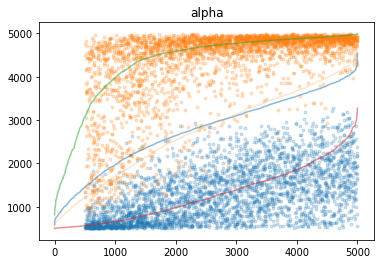

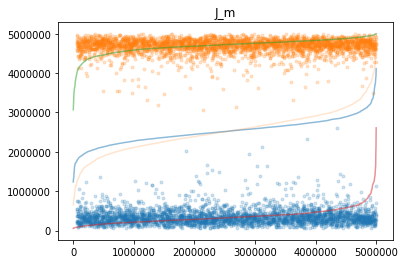

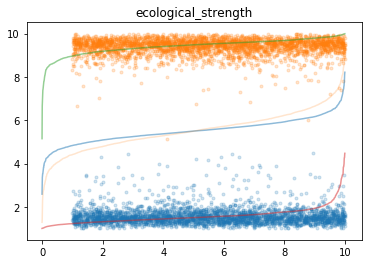

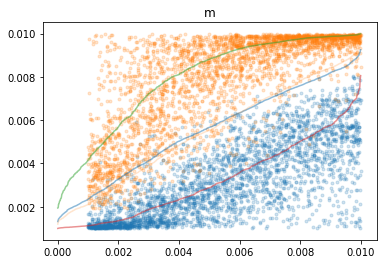

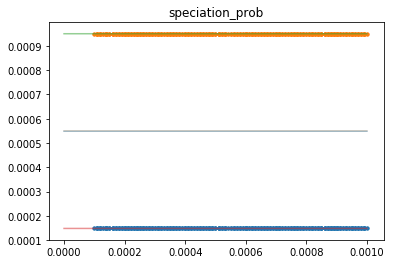

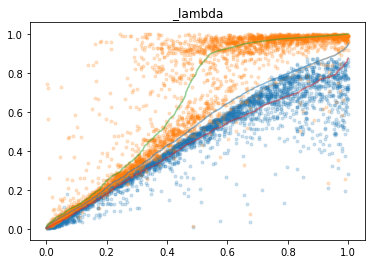

In [72]:
def quantile_forest(X, y, t):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    rfqr = RandomForestQuantileRegressor(random_state=0, n_estimators=200)

    rfqr.fit(X_train, y_train)
    y_mean = rfqr.predict(X_test)
    y_median = rfqr.predict(X_test, 50)
    y_lower = rfqr.predict(X_test, 5)
    y_upper = rfqr.predict(X_test, 95)

    fig, ax = plt.subplots()
    xs = np.linspace(0, max(y_train), len(y_mean))
    ax.plot(xs, sorted(y_mean), alpha=0.5)
    ax.plot(xs, sorted(y_median), alpha=0.2)
    ax.plot(xs, sorted(y_upper), alpha=0.5)
    ax.plot(xs, sorted(y_lower), alpha=0.5)
    ax.scatter(y_test, y_lower, marker='.', alpha=.2)
    ax.scatter(y_test, y_upper, marker='.', alpha=.2)
    ax.set_title(t)
    
for t in rgr.targets:
    print("Doing {}".format(t))
    quantile_forest(rgr.X, rgr.y[t], t)

In [89]:
### Use QuantileForests for quantile estimation
from skgarden import RandomForestQuantileRegressor
from sklearn.ensemble import RandomForestRegressor
rfqr = RandomForestQuantileRegressor(random_state=0, n_estimators=200)
rf = RandomForestRegressor(random_state=0, n_estimators=200)

X_train, X_test, y_train, y_test = train_test_split(rgr.X[:1000], rgr.y["alpha"][:1000])

rfqr.fit(X_train, y_train)
rf.fit(X_train, y_train)
rf_y_mean = rf.predict(X_test)
y_mean = rfqr.predict(X_test)
y_median = rfqr.predict(X_test, 50)
y_lower = rfqr.predict(X_test, 5)
y_upper = rfqr.predict(X_test, 95)

(array([3009.355, 3608.5  , 2653.575, 3419.815, 1549.835, 3768.115,
       3636.34 , 2833.55 , 2304.78 , 1695.215]), array([3009.355, 3608.5  , 2653.575, 3419.815, 1549.835, 3768.115,
       3636.34 , 2833.55 , 2304.78 , 1695.215]))


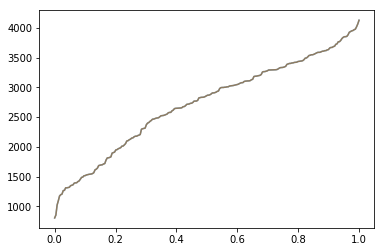

In [90]:

xs = np.linspace(0, 1, len(y_mean))
plt.plot(xs, sorted(y_mean))
plt.plot(xs, sorted(rf_y_mean), alpha=.5)
print(y_mean[:10], rf_y_mean[:10])

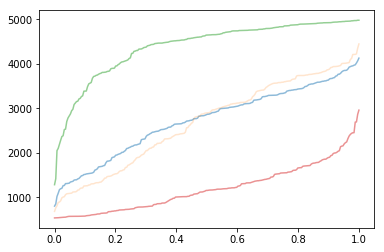

In [91]:
xs = np.linspace(0, 1, len(y_mean))
plt.plot(xs, sorted(y_mean), alpha=0.5)
plt.plot(xs, sorted(y_median), alpha=0.2)
plt.plot(xs, sorted(y_upper), alpha=0.5)
plt.plot(xs, sorted(y_lower), alpha=0.5)
#plt.scatter(y_test, y_lower, marker='.')
#plt.scatter(y_test, y_upper, marker='.')

## Mean upper/lower 90% for the spider data

In [66]:
sp_mean = rfqr.predict(rgr.empirical_sumstats)
sp_lower = rfqr.predict(rgr.empirical_sumstats, 5)
sp_upper = rfqr.predict(rgr.empirical_sumstats, 95)
fake_posterior = [rfqr.predict(rgr.empirical_sumstats, x) for x in range(0, 101)]
print(sp_mean, "{}/{}".format(sp_lower, sp_upper))

(array([0.93797]), '[0.85066668]/[0.98900002]')


(array([0.81900001]), array([1.]))


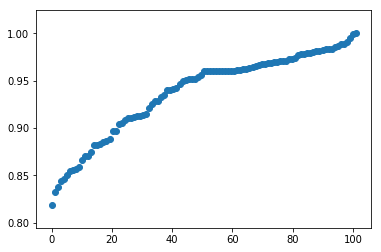

In [68]:
xs = np.linspace(0, 101, len(fake_posterior))
print(min(fake_posterior), max(fake_posterior))
plt.scatter(xs, fake_posterior)

# sklearn GB has quantile regression built in (sort of)
This works okay for GB, I guess.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=1000, max_depth=5,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(rgr.X, rgr.y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(rgr.empirical_sumstats)

clf.set_params(alpha=1.0 - alpha)
clf.fit(rgr.X, rgr.y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(rgr.empirical_sumstats)

clf.set_params(loss='ls')
clf.fit(rgr.X, rgr.y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(rgr.empirical_sumstats)

print(y_upper, y_lower, y_pred)

## forestci: Again, not sure if this is useful
    
    cd /home/isaac/Continuosity/MESS/util
    git clone https://github.com/scikit-learn-contrib/forest-confidence-interval.git
    cd forest-confidence-interval
    python setup.py install

In [ ]:
import forestci as fci
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(rgr.X, rgr.y)
v = fci.random_forest_error(rgr.best_model, X_train, X_test)
v

# Trash below here

(array([595., 655., 532., 583., 648., 570., 680., 474., 652., 544., 657.,
        529., 656., 554., 644., 538., 654., 614., 618., 577.]),
 array([0.0001  , 0.000145, 0.00019 , 0.000235, 0.00028 , 0.000325,
        0.00037 , 0.000415, 0.00046 , 0.000505, 0.00055 , 0.000595,
        0.00064 , 0.000685, 0.00073 , 0.000775, 0.00082 , 0.000865,
        0.00091 , 0.000955, 0.001   ]),
 <a list of 20 Patch objects>)

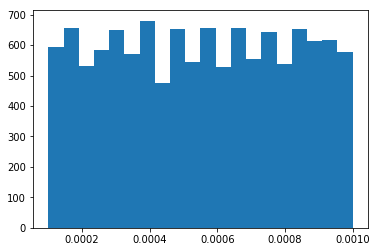

In [74]:
sim_df = pd.read_csv(simfile, sep="\t", header=0)
plt.hist(sim_df["speciation_prob"], bins=20)